Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [1]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Model, Sequential
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.optimizers import Adam
import keras as k
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report
!pip install tensorflow-addons
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow_addons.text import crf_log_likelihood, crf_decode
!pip install transformers

BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name'].replace("_CWR","")

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=e79a28792023c66dec48e6e57a51f6059e79cb02d93584d781e4047921ff419d
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 4.2 MB/s 
     |████████████████████████████████| 163 kB 56.5 MB/s 
     |████████████████████████████████| 7.6 MB 51.9 MB/s 
[11393, 14339, 15822, 18213, 1801, 17892, 8574, 10702, 2615,

In [2]:
from transformers import pipeline, AutoTokenizer
from future.utils import iteritems

tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    unmasker = pipeline('fill-mask', model='allenai/scibert_scivocab_uncased')
    
    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))

    found_subset = False

    while not found_subset:
      random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
      base_labels = [labels[i] for i in random_idxs]
      found_subset = all([tag2idx["O"] in labels for labels in base_labels])

    base_sequences = [dataset[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
      sequence_str = [idx2word[word] for word in sequence]

      # check max number of tokens bert support and truncate sentence before augmentation
      # augmented sentence will be shorter than original sentence if higher than bert limit
      encoding = tokenizer(sequence_str,
                             is_split_into_words=True, 
                             return_offsets_mapping=True, 
                             truncation=True, 
                             max_length=512)
      
      max_n_of_tokens = len([mapping for mapping in encoding["offset_mapping"] if mapping[0] == 0 and mapping[1] != 0])

      truncated_sequence_str = sequence_str[:max_n_of_tokens]
      truncated_labels = base_labels[k][:max_n_of_tokens]

      # print(len(sequence_str),len(truncated_sequence_str),len(base_labels[k]),len(truncated_labels))

      replaceable_indices = [i for i,label in enumerate(truncated_labels) if label == tag2idx["O"]]
      replace_percent = round(random.uniform(0.1, 1), 1)
      replace_qty = max(math.floor(replace_percent*len(replaceable_indices)), 1)
      replace_indices = random.sample(replaceable_indices, k=replace_qty)
      replace_indices.sort()

      masked_text_list = ["[MASK]" if i in replace_indices else word for i,word in enumerate(truncated_sequence_str)]
      new_mask_sent = ' '.join(masked_text_list)
      augmented_text_list = unmasker(new_mask_sent)

      augmented_sentence = truncated_sequence_str.copy()
      if len(replace_indices) == 1:
        augmented_text_list = [augmented_text_list]

      for i,index in enumerate(replace_indices):
        available_words = [word["token_str"] for word in augmented_text_list[i] if word["token_str"] != truncated_sequence_str[index]]
        new_word = random.choice(available_words)
        if new_word != "[UNK]":
          augmented_sentence[index] = new_word

      # print("Original text->",len(sequence_str),sequence_str)
      # print("Augmented text->",len(sequence_str),augmented_sentence)

      new_sequences.append(augmented_sentence)
      new_labels.append(truncated_labels)

    all_words = list(set([word for seq in new_sequences for word in seq]))
    updated_word2idx = word2idx.copy()
    updated_idx2word = idx2word.copy()
    for word in all_words:
      try:
        updated_word2idx[word]
      except:
        updated_word2idx[word] = len(updated_word2idx)
    updated_idx2word = {i: w for w, i in iteritems(updated_word2idx)}

    updated_n_words = len(updated_idx2word.items())

    new_sequences = [[updated_word2idx[word] for word in seq] for seq in new_sequences]

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [3]:
# Graph plot function 
plt.style.use('ggplot')

def plot_history(history):
    # accuracy = history.history['crf_viterbi_accuracy']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [4]:
# This function converts predicted values to labels from idx2tag
# This is to improve the interpretability of the results
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -oq glove.6B.zip

--2022-10-28 07:22:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-10-28 07:22:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-10-28 07:22:36--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [6]:
path_to_glove_file = "./glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [7]:
embedding_dim = 100

def generate_embedding_matrix(n_words, word2idx):
  num_tokens = n_words + 1
  hits = 0
  misses = 0

  # Prepare embedding matrix
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # Words not found in embedding index will be all-zeros.
          # This includes the representation for "padding" and "OOV"
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print("Converted %d words (%d misses)" % (hits, misses))
  return embedding_matrix

In [8]:
class CRF(L.Layer):
    def __init__(self,
                 output_dim,
                 sparse_target=True,
                 **kwargs):
        """    
        Args:
            output_dim (int): the number of labels to tag each temporal input.
            sparse_target (bool): whether the the ground-truth label represented in one-hot.
        Input shape:
            (batch_size, sentence length, output_dim)
        Output shape:
            (batch_size, sentence length, output_dim)
        """
        super(CRF, self).__init__(**kwargs)
        self.output_dim = int(output_dim) 
        self.sparse_target = sparse_target
        self.input_spec = L.InputSpec(min_ndim=3)
        self.supports_masking = False
        self.sequence_lengths = None
        self.transitions = None

    def build(self, input_shape):
        assert len(input_shape) == 3
        f_shape = tf.TensorShape(input_shape)
        input_spec = L.InputSpec(min_ndim=3, axes={-1: f_shape[-1]})

        if f_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `CRF` '
                             'should be defined. Found `None`.')
        if f_shape[-1] != self.output_dim:
            raise ValueError('The last dimension of the input shape must be equal to output'
                             ' shape. Use a linear layer if needed.')
        self.input_spec = input_spec
        self.transitions = self.add_weight(name='transitions',
                                           shape=[self.output_dim, self.output_dim],
                                           initializer='glorot_uniform',
                                           trainable=True)
        self.built = True

    def compute_mask(self, inputs, mask=None):
        # Just pass the received mask from previous layer, to the next layer or
        # manipulate it if this layer changes the shape of the input
        return mask

    def call(self, inputs, sequence_lengths=None, training=None, **kwargs):
        sequences = tf.convert_to_tensor(inputs, dtype=self.dtype)
        if sequence_lengths is not None:
            assert len(sequence_lengths.shape) == 2
            assert tf.convert_to_tensor(sequence_lengths).dtype == 'int32'
            seq_len_shape = tf.convert_to_tensor(sequence_lengths).get_shape().as_list()
            assert seq_len_shape[1] == 1
            self.sequence_lengths = K.flatten(sequence_lengths)
        else:
            self.sequence_lengths = tf.ones(tf.shape(inputs)[0], dtype=tf.int32) * (
                tf.shape(inputs)[1]
            )

        viterbi_sequence, _ = crf_decode(sequences,
                                         self.transitions,
                                         self.sequence_lengths)
        output = K.one_hot(viterbi_sequence, self.output_dim)
        return K.in_train_phase(sequences, output)

    @property
    def loss(self):
        def crf_loss(y_true, y_pred):
            y_pred = tf.convert_to_tensor(y_pred, dtype=self.dtype)
            log_likelihood, self.transitions = crf_log_likelihood(
                y_pred,
                tf.cast(K.argmax(y_true), dtype=tf.int32) if self.sparse_target else y_true,
                self.sequence_lengths,
                transition_params=self.transitions,
            )
            return tf.reduce_mean(-log_likelihood)
        return crf_loss

    @property
    def accuracy(self):
        def viterbi_accuracy(y_true, y_pred):
            # -1e10 to avoid zero at sum(mask)
            mask = K.cast(
                K.all(K.greater(y_pred, -1e10), axis=2), K.floatx())
            shape = tf.shape(y_pred)
            sequence_lengths = tf.ones(shape[0], dtype=tf.int32) * (shape[1])
            y_pred, _ = crf_decode(y_pred, self.transitions, sequence_lengths)
            if self.sparse_target:
                y_true = K.argmax(y_true, 2)
            y_pred = K.cast(y_pred, 'int32')
            y_true = K.cast(y_true, 'int32')
            corrects = K.cast(K.equal(y_true, y_pred), K.floatx())
            return K.sum(corrects * mask) / K.sum(mask)
        return viterbi_accuracy

    def compute_output_shape(self, input_shape):
        tf.TensorShape(input_shape).assert_has_rank(3)
        return input_shape[:2] + (self.output_dim,)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'sparse_target': self.sparse_target,
            'supports_masking': self.supports_masking,
            'transitions': K.eval(self.transitions)
        }
        base_config = super(CRF, self).get_config()
        return dict(base_config, **config)

In [9]:
# Model creation function
def create_model(maxlen, n_words, embedding_matrix):
    model = Sequential()
    model.add(Embedding(input_dim=n_words+1, output_dim=embedding_dim, 
                    input_length=maxlen, weights=[embedding_matrix], mask_zero=True))
    model.add(Bidirectional(LSTM(units=embedding_dim, return_sequences=True, 
                              dropout=0.1)))
    model.add(TimeDistributed(Dense(n_tags)))
    crf = CRF(n_tags, sparse_target=True)
    model.add(crf)
    adam = Adam(learning_rate=0.005)
    model.compile(optimizer=adam, loss=crf.loss, metrics=[crf.accuracy, 'accuracy'])
    model.summary()
    return model

In [10]:
# Model training function
def train(model, X_train_df, y_train_df, X_dev_df, y_dev_df):
  early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
  callbacks_list = [early_stopping]

  batch_size = round(0.05*len(X_train_df))
  if batch_size > 16:
    batch_size = 16
  if batch_size < 10:
    batch_size = 10

  history = model.fit(X_train_df, np.array(y_train_df),
                      batch_size=batch_size,
                      epochs=500,
                      validation_data=(X_dev_df,  np.array(y_dev_df)),
                      validation_batch_size=512,
                      verbose=1,
                      callbacks=callbacks_list)
  plot_history(history)

In [11]:
# Model testing function
def test(model, X_test_df, y_test_df):
  test_pred = model.predict(X_test_df, verbose=1)   

  pred_labels = pred2label(test_pred)
  test_labels = pred2label(y_test_df)
  
  print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
  report = classification_report(y_pred=pred_labels, y_true=test_labels, output_dict=True)
  df = pd.DataFrame(report).transpose()
  print("Classification Report:")
  print(df.to_csv())

In [12]:
def create_train_and_validate_model(augmented_percentage):
  augmented_X_train, augmented_y_train, updated_n_words, updated_word2idx = generate_sentences(X_train, y_train, augmented_percentage)

  # Preparing data for training. 
  # X = observations vector. For text sequence labeling, observations are the index of the words in the sentences
  # y = labels vector. For text sequence labeling, labels are the index of tags in the sentences
  # The BI-LSTM layer expects all texts/sentences to be of the same length. 
  # So, we need to pad shorter sentences
  # We select the padding size to be the length of the longest sentence.

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_dev = max([len(s) for s in y_dev])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_y_test = max([len(s) for s in y_test])

  maxlen = max([maxlen_X_train, maxlen_y_train, maxlen_X_dev, maxlen_y_dev, maxlen_X_test, maxlen_y_test])

  augmented_X_train = pad_sequences(maxlen=maxlen, sequences=augmented_X_train, padding="post",value=updated_word2idx["PAD"])
  new_X_dev = pad_sequences(maxlen=maxlen, sequences=X_dev, padding="post",value=updated_word2idx["PAD"])
  new_X_test = pad_sequences(maxlen=maxlen, sequences=X_test, padding="post",value=updated_word2idx["PAD"])

  augmented_y_train = pad_sequences(maxlen=maxlen, sequences=augmented_y_train, padding="post", value=tag2idx["O"])
  new_y_dev = pad_sequences(maxlen=maxlen, sequences=y_dev, padding="post", value=tag2idx["O"])
  new_y_test = pad_sequences(maxlen=maxlen, sequences=y_test, padding="post", value=tag2idx["O"])

  # Converts vector y (integers) to binary matrix.
  # Each y is a one-hot vector where only the position of the tag gests "1"
  augmented_y_train = [to_categorical(i, num_classes=n_tags) for i in augmented_y_train]
  new_y_dev = [to_categorical(i, num_classes=n_tags) for i in new_y_dev]
  new_y_test = [to_categorical(i, num_classes=n_tags) for i in new_y_test]

  embedding_matrix = generate_embedding_matrix(updated_n_words, updated_word2idx)

  model = None
  model = create_model(maxlen, updated_n_words, embedding_matrix)

  train(model, augmented_X_train, augmented_y_train, new_X_dev, new_y_dev)

  test(model, new_X_test, new_y_test)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Converted 10958 words (7751 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 651, 100)          1871000   
                                                                 
 bidirectional (Bidirectiona  (None, 651, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 651, 5)           1005      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 651, 5)            25        
                                                                 
Total params: 2,032,830
Trainable params: 2,032,830
Non-trainable pa

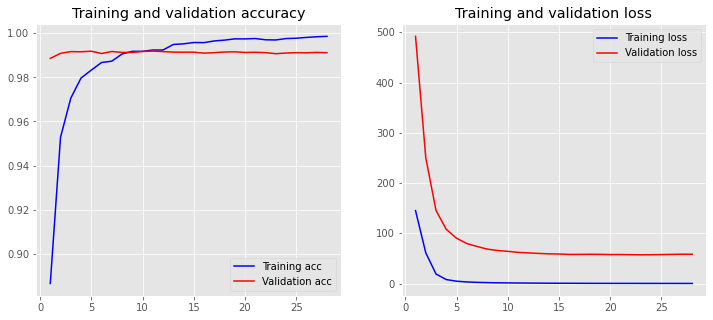

32/32 [==============================] - 9s 204ms/step
F1-score: 68.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7296488427773344,0.7255952380952381,0.727616394747314,5040.0
Disease,0.5963723340641818,0.6740256814597883,0.6328257191201353,4439.0
micro avg,0.662977365639645,0.7014453001371452,0.6816690588476522,9479.0
macro avg,0.6630105884207581,0.6998104597775132,0.6802210569337246,9479.0
weighted avg,0.6672356744918946,0.7014453001371452,0.6832260783522253,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Converted 10938 words (7742 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 651, 100)          1868100   
                                                                 
 bidirectional_1 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,029,930
Trainable params: 2,029,930
Non-trainable 

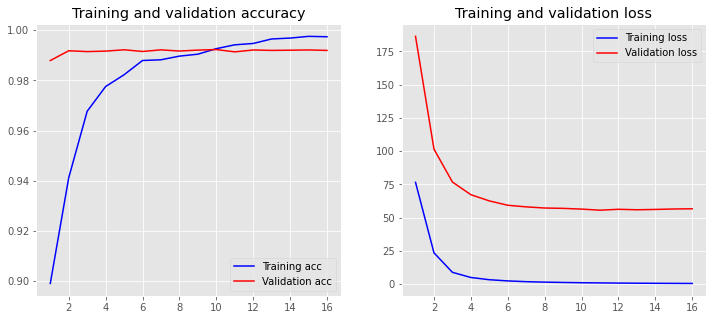

32/32 [==============================] - 10s 207ms/step
F1-score: 70.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8328638497652582,0.703968253968254,0.7630107526881721,5040.0
Disease,0.6026687910774746,0.6816850642036495,0.6397463002114165,4439.0
micro avg,0.7083288438745825,0.6935330731089777,0.7008528784648187,9479.0
macro avg,0.7177663204213665,0.6928266590859518,0.7013785264497943,9479.0
weighted avg,0.7250638850522008,0.6935330731089777,0.7052862137553397,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Converted 10960 words (7740 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 651, 100)          1870100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,031,930
Trainable params: 2,031,930
Non-trainable 

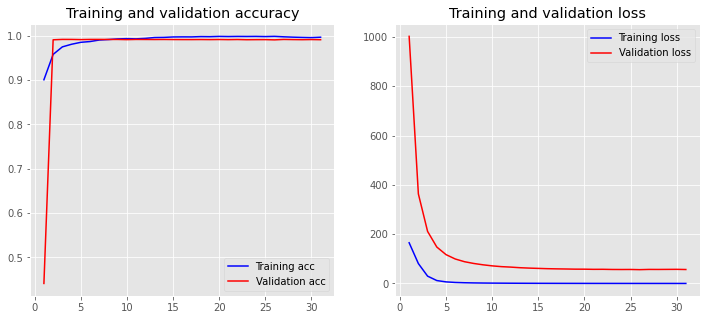

32/32 [==============================] - 9s 204ms/step
F1-score: 68.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6766837546402686,0.7595238095238095,0.7157146863606619,5040.0
Disease,0.6400523560209425,0.6609596756026132,0.6503380250471018,4439.0
micro avg,0.6602870813397129,0.7133663888595844,0.6858012170385396,9479.0
macro avg,0.6583680553306055,0.7102417425632113,0.6830263557038818,9479.0
weighted avg,0.659529331339162,0.7133663888595844,0.685098904150419,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Converted 10934 words (7747 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 651, 100)          1868200   
                                                                 
 bidirectional_3 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,030,030
Trainable params: 2,030,030
Non-trainable 

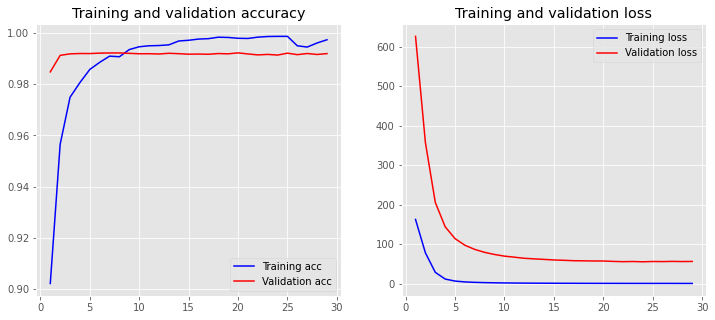

32/32 [==============================] - 9s 204ms/step
F1-score: 69.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7269013810542696,0.741468253968254,0.7341125626166389,5040.0
Disease,0.6312703583061889,0.6548772246001352,0.6428571428571428,4439.0
micro avg,0.6817155756207675,0.7009178183352675,0.691183355006502,9479.0
macro avg,0.6790858696802293,0.6981727392841945,0.6884848527368909,9479.0
weighted avg,0.6821175314943234,0.7009178183352675,0.6913778006889668,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Converted 10966 words (7746 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 651, 100)          1871300   
                                                                 
 bidirectional_4 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,033,130
Trainable params: 2,033,130
Non-trainable 

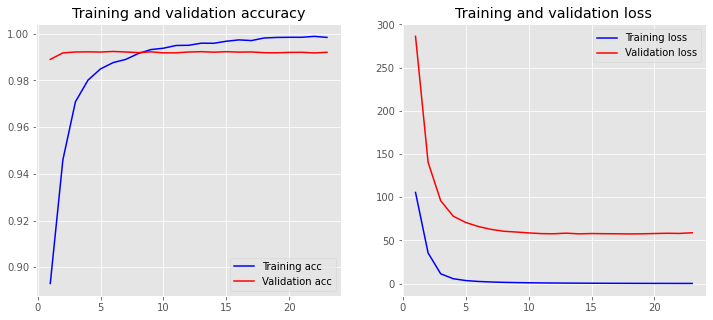

32/32 [==============================] - 9s 205ms/step
F1-score: 71.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7707378074197583,0.7337301587301587,0.7517788168326895,5040.0
Disease,0.6523706896551724,0.6819103401667043,0.6668135257186915,4439.0
micro avg,0.7125450307268489,0.7094630235256884,0.7110006872125602,9479.0
macro avg,0.7115542485374653,0.7078202494484315,0.7092961712756904,9479.0
weighted avg,0.7153066822212145,0.7094630235256884,0.7119897117314091,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Converted 10972 words (7742 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 651, 100)          1871500   
                                                                 
 bidirectional_5 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,033,330
Trainable params: 2,033,330
Non-trainable 

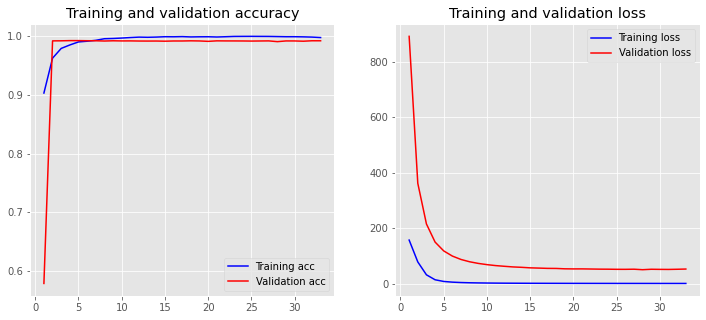

32/32 [==============================] - 10s 210ms/step
F1-score: 67.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.622558667676003,0.8158730158730159,0.706225848003435,5040.0
Disease,0.6139525368248773,0.6760531651272809,0.6435080947785998,4439.0
micro avg,0.6188984599321325,0.7503956113514084,0.6783330154491704,9479.0
macro avg,0.6182556022504402,0.7459630905001484,0.6748669713910174,9479.0
weighted avg,0.6185284308526938,0.7503956113514084,0.6768552280472114,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Converted 10950 words (7740 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 651, 100)          1869100   
                                                                 
 bidirectional_6 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,030,930
Trainable params: 2,030,930
Non-trainable 

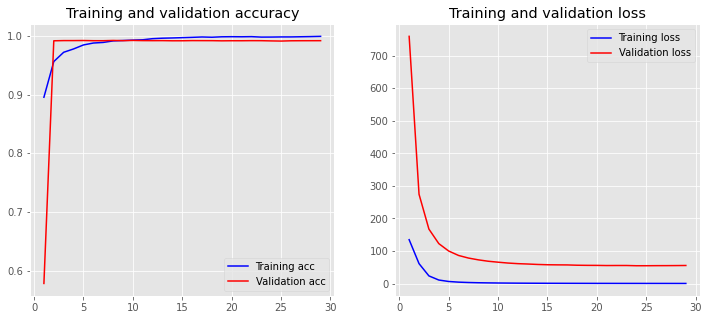

32/32 [==============================] - 10s 207ms/step
F1-score: 69.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7556923076923077,0.7309523809523809,0.7431164901664146,5040.0
Disease,0.6234150464919695,0.664564091011489,0.6433322429397013,4439.0
micro avg,0.6905381492661601,0.6998628547315118,0.6951692339935032,9479.0
macro avg,0.6895536770921387,0.697758235981935,0.693224366553058,9479.0
weighted avg,0.6937470853620723,0.6998628547315118,0.6963876924620808,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Converted 10976 words (7752 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 651, 100)          1872900   
                                                                 
 bidirectional_7 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,034,730
Trainable params: 2,034,730
Non-trainable 

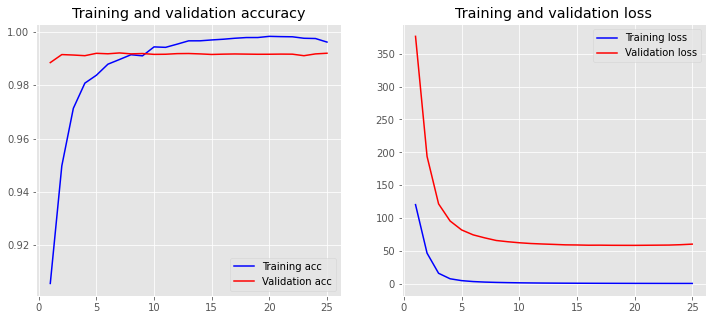

32/32 [==============================] - 10s 209ms/step
F1-score: 70.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7491928974979822,0.7367063492063493,0.7428971588635455,5040.0
Disease,0.643655489809336,0.6616355034917775,0.6525216618529216,4439.0
micro avg,0.6986027944111777,0.7015507964975208,0.7000736919675756,9479.0
macro avg,0.696424193653659,0.6991709263490633,0.6977094103582335,9479.0
weighted avg,0.6997699042782438,0.7015507964975208,0.7005744633017605,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Converted 10941 words (7732 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 651, 100)          1867400   
                                                                 
 bidirectional_8 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,029,230
Trainable params: 2,029,230
Non-trainable 

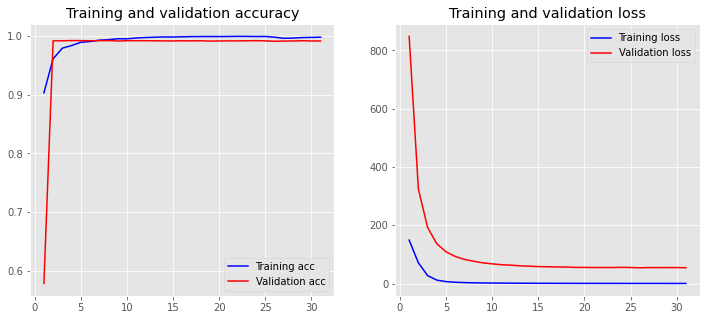

32/32 [==============================] - 10s 206ms/step
F1-score: 68.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7592208868628264,0.726984126984127,0.7427528887086966,5040.0
Disease,0.582247403210576,0.6945257940977698,0.6334497637148141,4439.0
micro avg,0.6666337318446793,0.7117839434539508,0.688469387755102,9479.0
macro avg,0.6707341450367013,0.7107549605409484,0.6881013262117553,9479.0
weighted avg,0.6763444975883945,0.7117839434539508,0.6915664163120467,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 938
Points in y_train after augmentation: 938
Converted 10969 words (7753 misses)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 651, 100)          1872300   
                                                                 
 bidirectional_9 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_9 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_9 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,034,130
Trainable params: 2,034,130
Non-trainable 

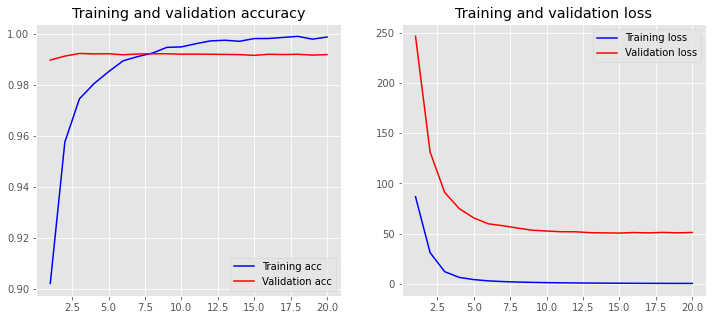

32/32 [==============================] - 10s 207ms/step
F1-score: 70.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7582034454470877,0.733531746031746,0.7456635740217828,5040.0
Disease,0.6391578947368421,0.6839378238341969,0.6607900750897813,4439.0
micro avg,0.6994597963847912,0.7103069944086929,0.7048416644857367,9479.0
macro avg,0.698680670091965,0.7087347849329715,0.703226824555782,9479.0
weighted avg,0.7024546112237752,0.7103069944086929,0.7059174550472965,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Converted 10996 words (7777 misses)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 651, 100)          1877400   
                                                                 
 bidirectional_10 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_10 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,039,230
Trainable params: 2,039,230
Non-trainab

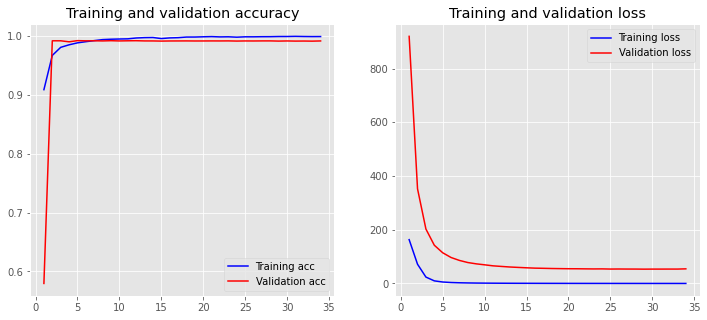

32/32 [==============================] - 10s 205ms/step
F1-score: 69.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.711864406779661,0.7416666666666667,0.7264600136041203,5040.0
Disease,0.647939262472885,0.6728993016445145,0.660183445684606,4439.0
micro avg,0.6819795152621438,0.7094630235256884,0.6954498448810754,9479.0
macro avg,0.6799018346262731,0.7072829841555905,0.6933217296443631,9479.0
weighted avg,0.6819283675795577,0.7094630235256884,0.6954228066208178,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Converted 10995 words (7801 misses)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 651, 100)          1879700   
                                                                 
 bidirectional_11 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_11 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_11 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,041,530
Trainable params: 2,041,530
Non-trainab

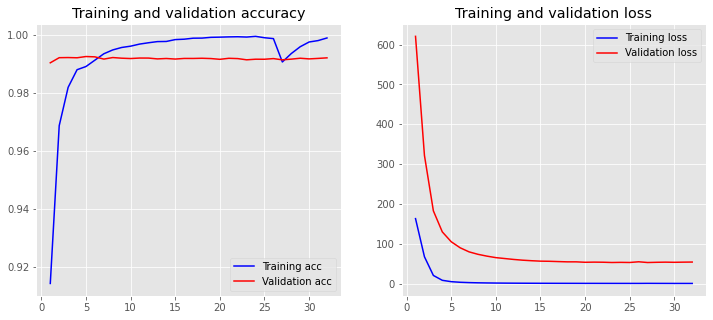

32/32 [==============================] - 10s 204ms/step
F1-score: 69.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6948829141370338,0.7948412698412698,0.7415085608514578,5040.0
Disease,0.6186085498742665,0.6650146429375986,0.6409727499728585,4439.0
micro avg,0.6603397551485243,0.7340436754931955,0.6952438049560352,9479.0
macro avg,0.6567457320056502,0.7299279563894342,0.6912406554121582,9479.0
weighted avg,0.6591637556854647,0.7340436754931955,0.6944278071337553,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Converted 11002 words (7812 misses)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 651, 100)          1881500   
                                                                 
 bidirectional_12 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_12 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_12 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,043,330
Trainable params: 2,043,330
Non-trainab

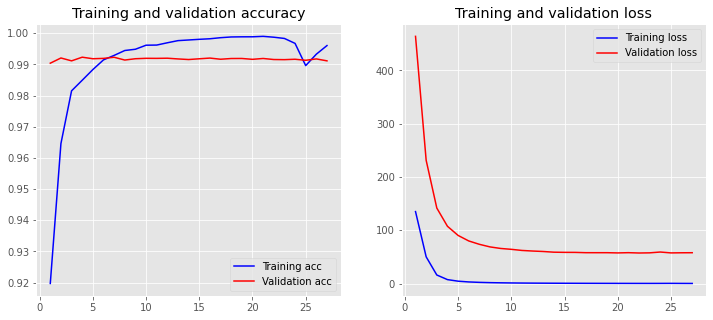

32/32 [==============================] - 10s 202ms/step
F1-score: 71.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.788922808547754,0.7178571428571429,0.7517141076251816,5040.0
Disease,0.663011859476393,0.6674926785312008,0.665244723843736,4439.0
micro avg,0.7267807840971838,0.6942715476316067,0.7101543109960072,9479.0
macro avg,0.7259673340120735,0.6926749106941719,0.7084794157344588,9479.0
weighted avg,0.7299589196430412,0.6942715476316067,0.7112206384189534,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Converted 11001 words (7800 misses)
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 651, 100)          1880200   
                                                                 
 bidirectional_13 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_13 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_13 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,042,030
Trainable params: 2,042,030
Non-trainab

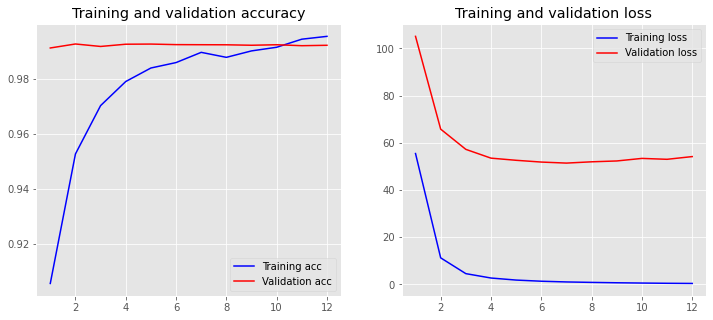

32/32 [==============================] - 10s 206ms/step
F1-score: 72.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7676665995570767,0.756547619047619,0.7620665534126111,5040.0
Disease,0.6835981203848736,0.688218067132237,0.6859003143242028,4439.0
micro avg,0.7278507842306062,0.7245490030593944,0.7261961406291304,9479.0
macro avg,0.7256323599709751,0.722382843089928,0.723983433868407,9479.0
weighted avg,0.7282974700027556,0.7245490030593944,0.7263980298011073,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Converted 11034 words (7814 misses)
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 651, 100)          1884900   
                                                                 
 bidirectional_14 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_14 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_14 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,046,730
Trainable params: 2,046,730
Non-trainab

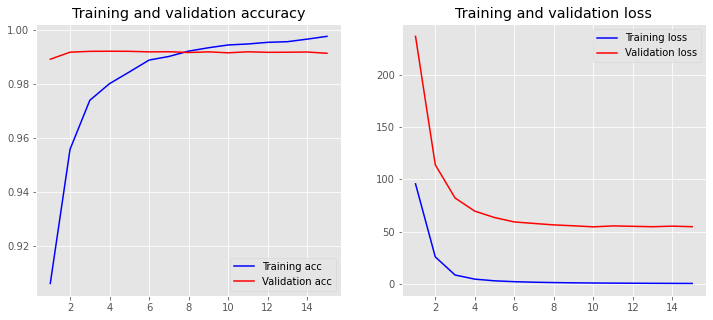

32/32 [==============================] - 10s 205ms/step
F1-score: 69.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7551104687177369,0.7255952380952381,0.7400586866336133,5040.0
Disease,0.6357020547945206,0.6690696102725839,0.6519591702337834,4439.0
micro avg,0.6964792433000525,0.6991243802088828,0.6977993050436979,9479.0
macro avg,0.6954062617561287,0.697332424183911,0.6960089284336983,9479.0
weighted avg,0.6991917062527978,0.6991243802088828,0.6988018290221727,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Converted 11016 words (7798 misses)
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 651, 100)          1881500   
                                                                 
 bidirectional_15 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_15 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_15 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,043,330
Trainable params: 2,043,330
Non-trainab

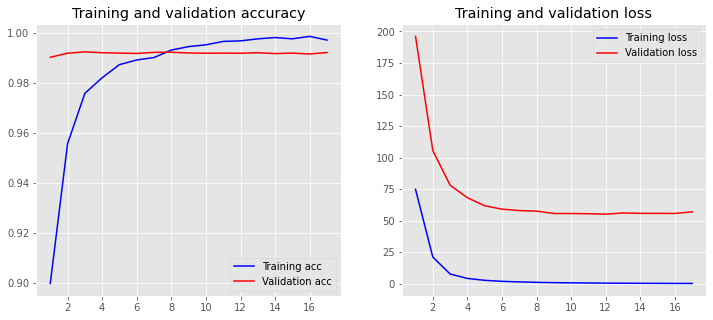

32/32 [==============================] - 10s 218ms/step
F1-score: 70.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7539213689142391,0.7343253968253968,0.7439943712935974,5040.0
Disease,0.6411411411411412,0.673349853570624,0.6568508955059884,4439.0
micro avg,0.6989865217845576,0.7057706509125435,0.7023622047244095,9479.0
macro avg,0.6975312550276902,0.7038376251980104,0.7004226333997929,9479.0
weighted avg,0.7011065750451831,0.7057706509125435,0.7031852259173766,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Converted 11036 words (7813 misses)
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 651, 100)          1885000   
                                                                 
 bidirectional_16 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_16 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_16 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,046,830
Trainable params: 2,046,830
Non-trainab

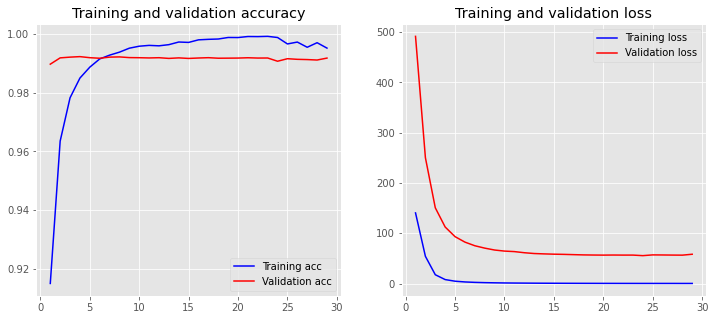

32/32 [==============================] - 9s 201ms/step
F1-score: 68.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6493738819320215,0.7922619047619047,0.7137367056930914,5040.0
Disease,0.6465669014084507,0.6618607794548321,0.654124457308249,4439.0
micro avg,0.6481810530253437,0.7311952737630552,0.6871901645845727,9479.0
macro avg,0.6479703916702362,0.7270613421083685,0.6839305815006702,9479.0
weighted avg,0.6480593776020152,0.7311952737630552,0.685820388509811,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Converted 10996 words (7793 misses)
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 651, 100)          1879000   
                                                                 
 bidirectional_17 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_17 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_17 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,040,830
Trainable params: 2,040,830
Non-trainab

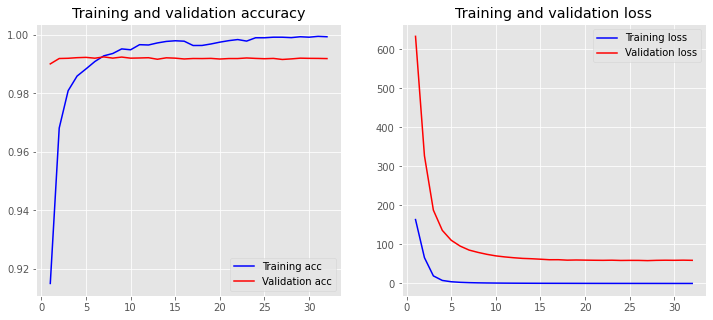

32/32 [==============================] - 10s 209ms/step
F1-score: 69.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7588769611890999,0.7293650793650793,0.7438284095507891,5040.0
Disease,0.6290118243243243,0.6710970939400766,0.6493732970027248,4439.0
micro avg,0.6946764091858038,0.7020782782993986,0.6983577312555748,9479.0
macro avg,0.6939443927567122,0.7002310866525779,0.6966008532767569,9479.0
weighted avg,0.6980613326900241,0.7020782782993986,0.6995952367898589,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Converted 11006 words (7830 misses)
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 651, 100)          1883700   
                                                                 
 bidirectional_18 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_18 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_18 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,045,530
Trainable params: 2,045,530
Non-trainab

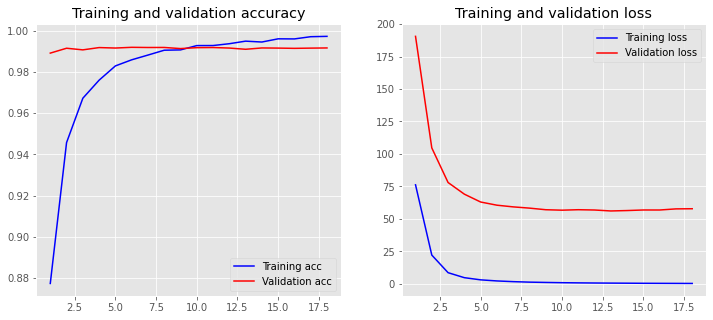

32/32 [==============================] - 10s 209ms/step
F1-score: 69.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7819935691318328,0.7238095238095238,0.7517774343122102,5040.0
Disease,0.6185331394140868,0.6706465420139671,0.643536532641591,4439.0
micro avg,0.6989871280860941,0.6989133874881317,0.6989502558421691,9479.0
macro avg,0.7002633542729598,0.6972280329117455,0.6976569834769006,9479.0
weighted avg,0.7054453206333546,0.6989133874881317,0.7010883993384915,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1125
Points in y_train after augmentation: 1125
Converted 11004 words (7809 misses)
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, 651, 100)          1881400   
                                                                 
 bidirectional_19 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_19 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_19 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,043,230
Trainable params: 2,043,230
Non-trainab

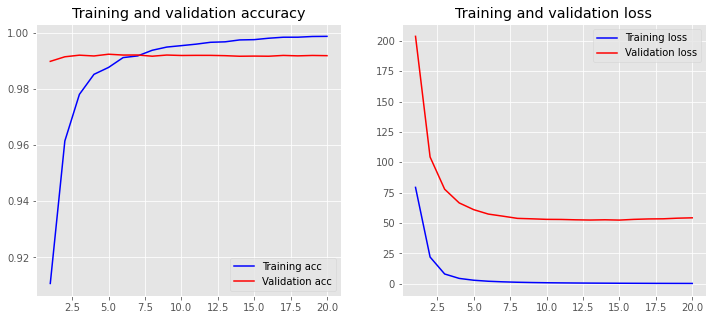

32/32 [==============================] - 9s 204ms/step
F1-score: 71.0%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7405963749756382,0.753968253968254,0.7472224953298594,5040.0
Disease,0.672060164083865,0.6643388150484343,0.6681771836411011,4439.0
micro avg,0.709003046538502,0.711994936174702,0.710495841667544,9479.0
macro avg,0.7063282695297517,0.7091535345083442,0.7076998394854803,9479.0
weighted avg,0.7085009809310575,0.711994936174702,0.710205706788199,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Converted 11080 words (7855 misses)
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 651, 100)          1893600   
                                                                 
 bidirectional_20 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_20 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_20 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,055,430
Trainable params: 2,055,430
Non-trainab

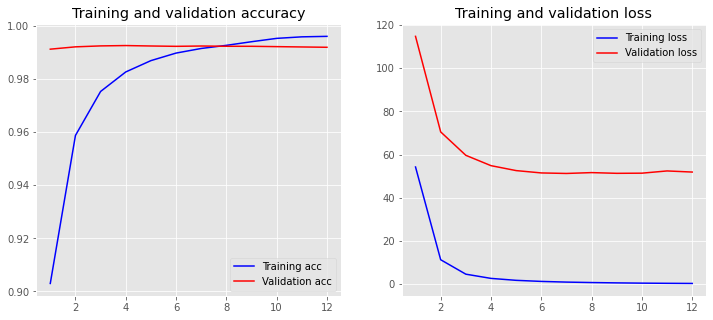

32/32 [==============================] - 10s 206ms/step
F1-score: 72.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8154053447114304,0.7204365079365079,0.7649847255872748,5040.0
Disease,0.7021785970792435,0.6607343996395585,0.6808263695450325,4439.0
micro avg,0.7606025492468135,0.692478109505222,0.7249433983102325,9479.0
macro avg,0.758791970895337,0.6905854537880332,0.7229055475661537,9479.0
weighted avg,0.7623814463319306,0.692478109505222,0.7255735068435768,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Converted 11079 words (7830 misses)
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, 651, 100)          1891000   
                                                                 
 bidirectional_21 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_21 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_21 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,052,830
Trainable params: 2,052,830
Non-trainab

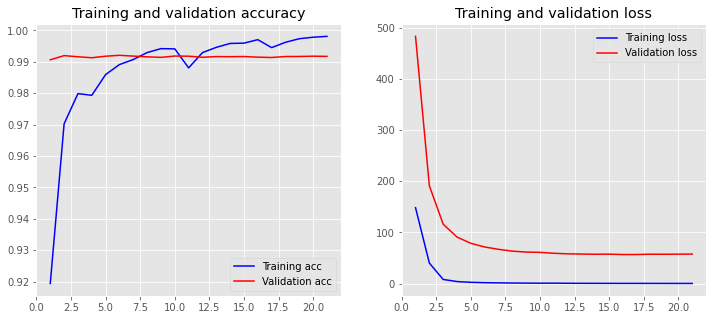

32/32 [==============================] - 10s 203ms/step
F1-score: 70.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7677486910994764,0.7273809523809524,0.7470198675496688,5040.0
Disease,0.6655443322109988,0.6679432304573102,0.6667416235664492,4439.0
micro avg,0.718418201516793,0.6995463656503851,0.7088566999839648,9479.0
macro avg,0.7166465116552376,0.6976620914191313,0.706880745558059,9479.0
weighted avg,0.719886559112352,0.6995463656503851,0.7094256988566092,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Converted 11057 words (7810 misses)
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 651, 100)          1886800   
                                                                 
 bidirectional_22 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_22 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_22 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,048,630
Trainable params: 2,048,630
Non-trainab

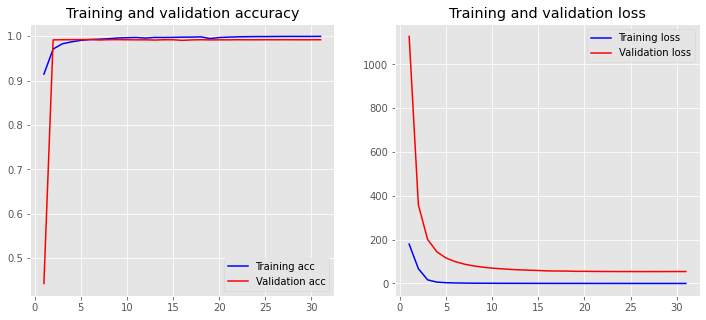

32/32 [==============================] - 10s 205ms/step
F1-score: 70.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7545510329310697,0.7319444444444444,0.7430758384530164,5040.0
Disease,0.6504424778761062,0.6623113313809417,0.6563232503627637,4439.0
micro avg,0.704538208098629,0.6993353729296339,0.7019271495129182,9479.0
macro avg,0.7024967554035879,0.697127887912693,0.6996995444078901,9479.0
weighted avg,0.7057971690330864,0.6993353729296339,0.7024497451380431,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Converted 11071 words (7827 misses)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, 651, 100)          1889900   
                                                                 
 bidirectional_23 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_23 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_23 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,051,730
Trainable params: 2,051,730
Non-trainab

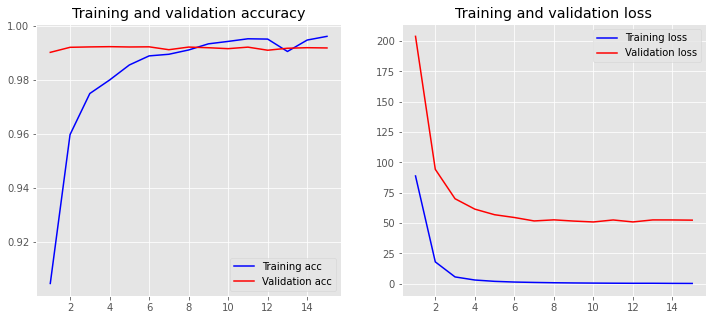

32/32 [==============================] - 10s 207ms/step
F1-score: 71.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7094339622641509,0.7833333333333333,0.7445544554455444,5040.0
Disease,0.6774119272392356,0.6627618833070511,0.6700068321566842,4439.0
micro avg,0.6953976584578119,0.726869922987657,0.7107855779646154,9479.0
macro avg,0.6934229447516933,0.7230476083201922,0.7072806438011143,9479.0
weighted avg,0.694438096299851,0.726869922987657,0.7096439269320672,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Converted 11081 words (7829 misses)
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 651, 100)          1891100   
                                                                 
 bidirectional_24 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_24 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_24 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,052,930
Trainable params: 2,052,930
Non-trainab

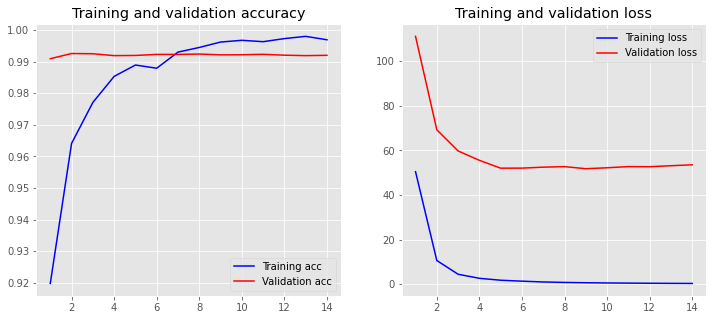

32/32 [==============================] - 10s 213ms/step
F1-score: 72.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8009613283810356,0.7273809523809524,0.7623999168139753,5040.0
Disease,0.6934204386374242,0.6695201621986934,0.6812607449856733,4439.0
micro avg,0.7489563353266389,0.7002848401730141,0.723803292988769,9479.0
macro avg,0.7471908835092299,0.6984505572898229,0.7218303308998244,9479.0
weighted avg,0.75060010783331,0.7002848401730141,0.7244025770370123,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Converted 11092 words (7868 misses)
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 651, 100)          1896100   
                                                                 
 bidirectional_25 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_25 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_25 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,057,930
Trainable params: 2,057,930
Non-trainab

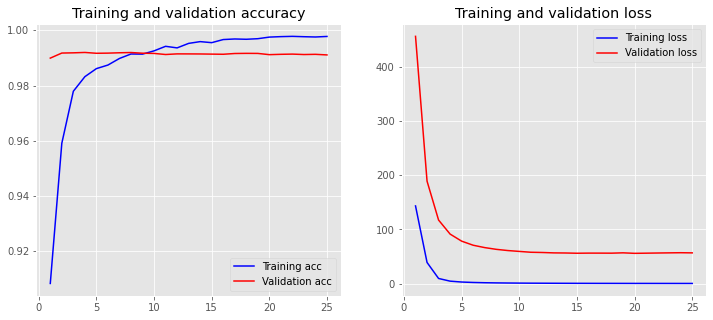

32/32 [==============================] - 10s 208ms/step
F1-score: 68.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6988924347662849,0.7386904761904762,0.7182405710427318,5040.0
Disease,0.6258078414476519,0.6544266726740257,0.6397973791432662,4439.0
micro avg,0.6648610693148761,0.6992298765692584,0.6816125051419168,9479.0
macro avg,0.6623501381069684,0.6965585744322509,0.6790189750929989,9479.0
weighted avg,0.664667040764659,0.6992298765692584,0.6815057542011105,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Converted 11089 words (7846 misses)
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 651, 100)          1893600   
                                                                 
 bidirectional_26 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_26 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_26 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,055,430
Trainable params: 2,055,430
Non-trainab

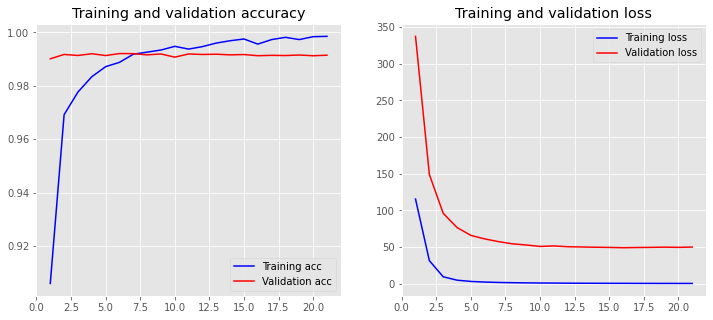

32/32 [==============================] - 10s 205ms/step
F1-score: 69.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6886108088501995,0.7533730158730159,0.7195376160697365,5040.0
Disease,0.6796856944765426,0.6625366073439964,0.6710015970796258,4439.0
micro avg,0.6846865155980083,0.7108344762105707,0.6975155279503105,9479.0
macro avg,0.684148251663371,0.7079548116085062,0.6952696065746812,9479.0
weighted avg,0.6844311925716192,0.7108344762105707,0.6968082787665293,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Converted 11072 words (7831 misses)
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_27 (Embedding)    (None, 651, 100)          1890400   
                                                                 
 bidirectional_27 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_27 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_27 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,052,230
Trainable params: 2,052,230
Non-trainab

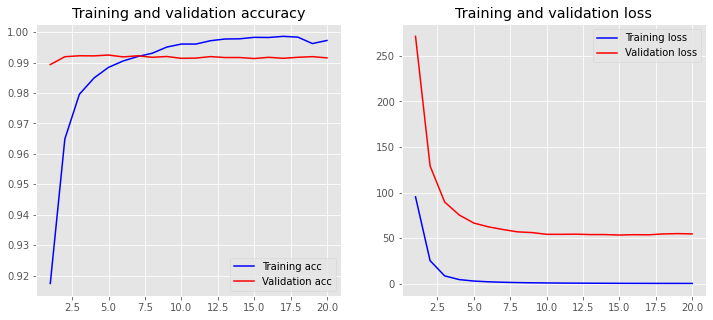

32/32 [==============================] - 9s 204ms/step
F1-score: 69.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.6874890331637129,0.7773809523809524,0.7296768786665425,5040.0
Disease,0.6585583575094844,0.6647893669745438,0.6616591928251121,4439.0
micro avg,0.67475442043222,0.72465449941977,0.6988147922071316,9479.0
macro avg,0.6730236953365987,0.7210851596777481,0.6956680357458274,9479.0
weighted avg,0.6739408456725092,0.72465449941977,0.697824309044208,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Converted 11065 words (7845 misses)
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 651, 100)          1891100   
                                                                 
 bidirectional_28 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_28 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_28 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,052,930
Trainable params: 2,052,930
Non-trainab

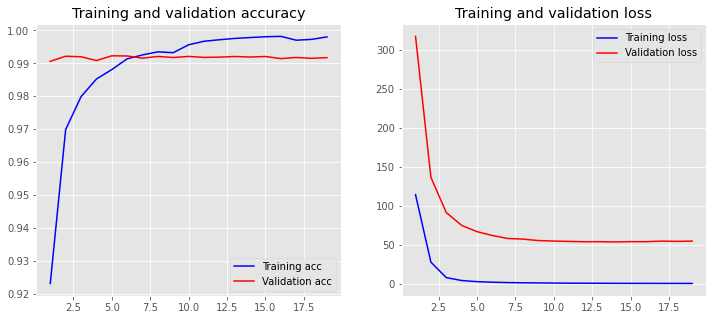

32/32 [==============================] - 10s 207ms/step
F1-score: 71.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7807577692635164,0.7277777777777777,0.7533374409529677,5040.0
Disease,0.6734364181860143,0.6573552601937374,0.6652986776105791,4439.0
micro avg,0.7292658620307828,0.6947990294334846,0.7116153430578066,9479.0
macro avg,0.7270970937247654,0.6925665189857575,0.7093180592817734,9479.0
weighted avg,0.7304993583095095,0.6947990294334846,0.7121090338977022,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1313
Points in y_train after augmentation: 1313
Converted 11083 words (7855 misses)
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 651, 100)          1893900   
                                                                 
 bidirectional_29 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_29 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_29 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,055,730
Trainable params: 2,055,730
Non-trainab

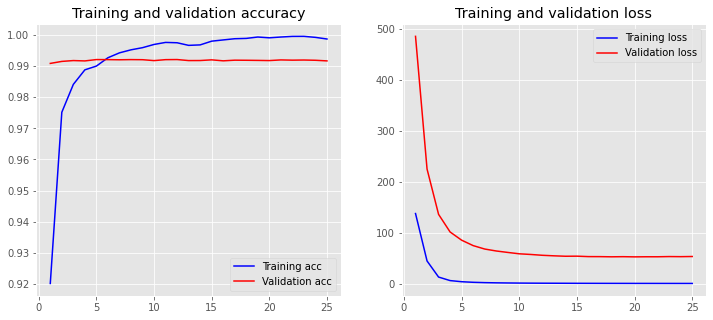

32/32 [==============================] - 10s 207ms/step
F1-score: 70.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7863097849934182,0.7111111111111111,0.7468222546363826,5040.0
Disease,0.6700983756577442,0.6598332957873395,0.6649262202043132,4439.0
micro avg,0.7294209877925859,0.6870977951260682,0.7076271186440678,9479.0
macro avg,0.7282040803255811,0.6854722034492253,0.7058742374203479,9479.0
weighted avg,0.7318881744816494,0.6870977951260682,0.7084704773556615,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11107 words (7875 misses)
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 651, 100)          1898300   
                                                                 
 bidirectional_30 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_30 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_30 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,060,130
Trainable params: 2,060,130
Non-trainab

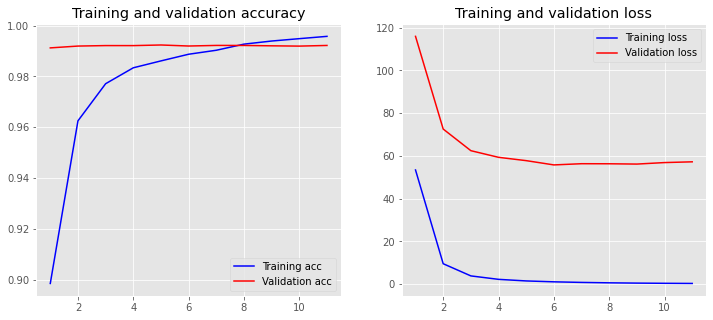

32/32 [==============================] - 10s 207ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7993413830954994,0.7224206349206349,0.7589369463262116,5040.0
Disease,0.6506101477199743,0.6846136517233611,0.6671789242590559,4439.0
micro avg,0.724040754389768,0.7047156873087879,0.7142475273990911,9479.0
macro avg,0.7249757654077369,0.703517143321998,0.7130579352926337,9479.0
weighted avg,0.7296907919116238,0.7047156873087879,0.7159668165703192,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11064 words (7871 misses)
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 651, 100)          1893600   
                                                                 
 bidirectional_31 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_31 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_31 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,055,430
Trainable params: 2,055,430
Non-trainab

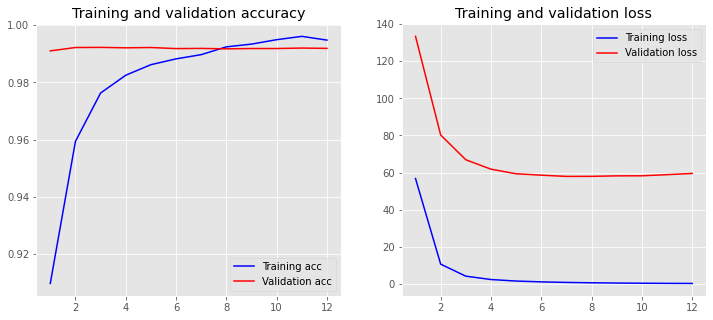

32/32 [==============================] - 10s 207ms/step
F1-score: 71.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8627101375445746,0.6720238095238096,0.7555208565692616,5040.0
Disease,0.6594155130740497,0.6760531651272809,0.667630700778643,4439.0
micro avg,0.7535684794148874,0.6739107500791223,0.7115170416573847,9479.0
macro avg,0.7610628253093121,0.6740384873255452,0.7115757786739523,9479.0
weighted avg,0.7675076016204623,0.6739107500791223,0.7143620421843522,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11133 words (7880 misses)
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 651, 100)          1901400   
                                                                 
 bidirectional_32 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_32 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_32 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,063,230
Trainable params: 2,063,230
Non-trainab

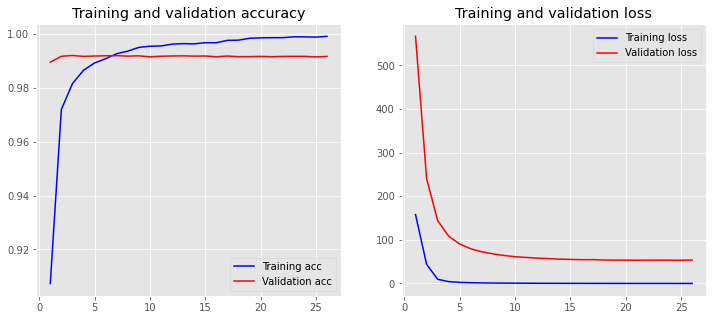

32/32 [==============================] - 10s 210ms/step
F1-score: 70.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8152173913043478,0.6845238095238095,0.7441760138050043,5040.0
Disease,0.6652986776105791,0.6573552601937374,0.6613031161473089,4439.0
micro avg,0.7389185425852867,0.6718008228716109,0.703763054649942,9479.0
macro avg,0.7402580344574634,0.6709395348587734,0.7027395649761565,9479.0
weighted avg,0.7450107059908507,0.6718008228716109,0.7053667730936941,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11129 words (7867 misses)
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 651, 100)          1899700   
                                                                 
 bidirectional_33 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_33 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_33 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,061,530
Trainable params: 2,061,530
Non-trainab

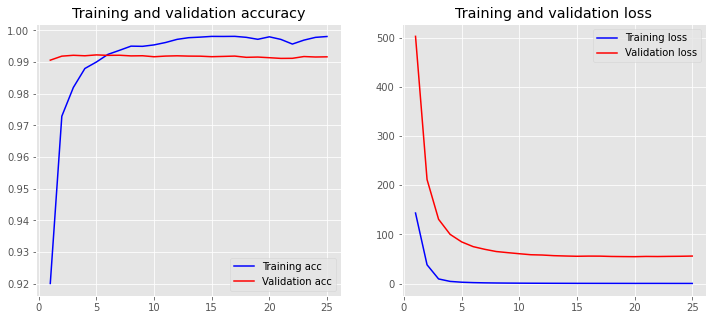

32/32 [==============================] - 10s 208ms/step
F1-score: 69.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7521685254027262,0.7226190476190476,0.7370977534911961,5040.0
Disease,0.652028533214445,0.6589321919351205,0.6554621848739497,4439.0
micro avg,0.7040094339622641,0.6927945985863487,0.6983569947360025,9479.0
macro avg,0.7020985293085855,0.690775619777084,0.696279969182573,9479.0
weighted avg,0.7052731329221078,0.6927945985863487,0.6988679519201488,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11116 words (7880 misses)
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 651, 100)          1899700   
                                                                 
 bidirectional_34 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_34 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_34 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,061,530
Trainable params: 2,061,530
Non-trainab

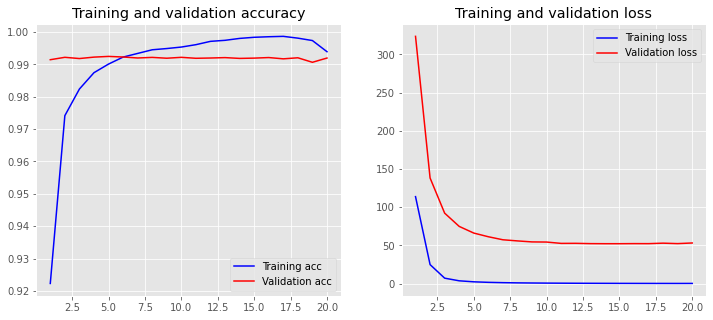

32/32 [==============================] - 10s 208ms/step
F1-score: 71.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7620326378847345,0.7319444444444444,0.7466855581418884,5040.0
Disease,0.6854536950420954,0.660283847713449,0.67263339070568,4439.0
micro avg,0.7261160469452671,0.6983859056862538,0.711981071198107,9479.0
macro avg,0.723743166463415,0.6961141460789466,0.7096594744237842,9479.0
weighted avg,0.7261708457886827,0.6983859056862538,0.7120070507835881,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11092 words (7853 misses)
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 651, 100)          1894600   
                                                                 
 bidirectional_35 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_35 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_35 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,056,430
Trainable params: 2,056,430
Non-trainab

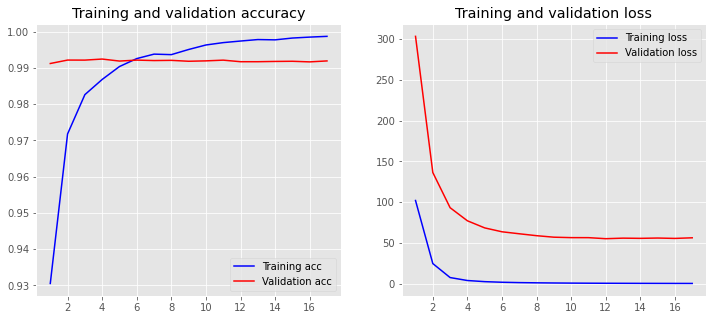

32/32 [==============================] - 10s 209ms/step
F1-score: 70.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7273254689615162,0.7462301587301587,0.7366565468612282,5040.0
Disease,0.66784140969163,0.6830367199819779,0.675353602851097,4439.0
micro avg,0.6995160127690249,0.7166367760312269,0.7079729025534133,9479.0
macro avg,0.6975834393265731,0.7146334393560683,0.7060050748561626,9479.0
weighted avg,0.6994691825284509,0.7166367760312269,0.7079484797169121,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11085 words (7872 misses)
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 651, 100)          1895800   
                                                                 
 bidirectional_36 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_36 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_36 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,057,630
Trainable params: 2,057,630
Non-trainab

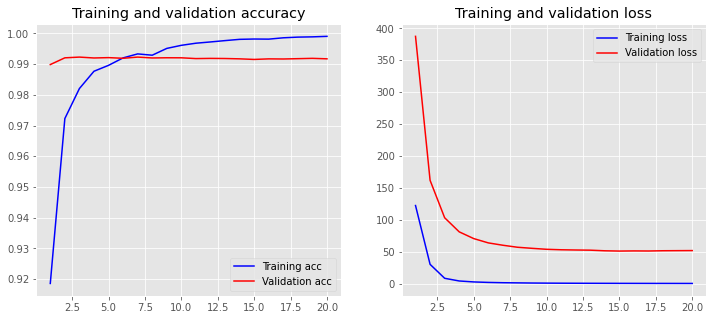

32/32 [==============================] - 10s 208ms/step
F1-score: 69.1%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7336783439490446,0.7313492063492063,0.7325119236883942,5040.0
Disease,0.6300900128589798,0.6623113313809417,0.6457990115321253,4439.0
micro avg,0.6837977296181631,0.6990188838485072,0.6913245344045073,9479.0
macro avg,0.6818841784040122,0.696830268865074,0.6891554676102598,9479.0
weighted avg,0.6851681000721802,0.6990188838485072,0.6919044105475907,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11104 words (7859 misses)
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 651, 100)          1896400   
                                                                 
 bidirectional_37 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_37 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_37 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,058,230
Trainable params: 2,058,230
Non-trainab

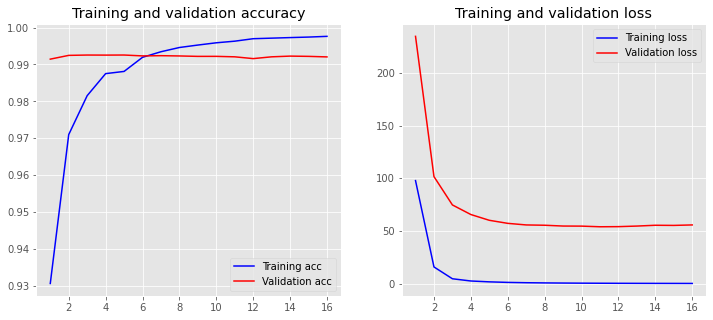

32/32 [==============================] - 10s 214ms/step
F1-score: 71.8%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7617504051863857,0.746031746031746,0.7538091419406575,5040.0
Disease,0.6862244897959183,0.6665915746789818,0.6762655696491829,4439.0
micro avg,0.7265354671280276,0.708830045363435,0.7175735568964596,9479.0
macro avg,0.7239874474911521,0.7063116603553639,0.7150373557949202,9479.0
weighted avg,0.7263817441020641,0.708830045363435,0.7174956154714249,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11116 words (7868 misses)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_38 (Embedding)    (None, 651, 100)          1898500   
                                                                 
 bidirectional_38 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_38 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_38 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,060,330
Trainable params: 2,060,330
Non-trainab

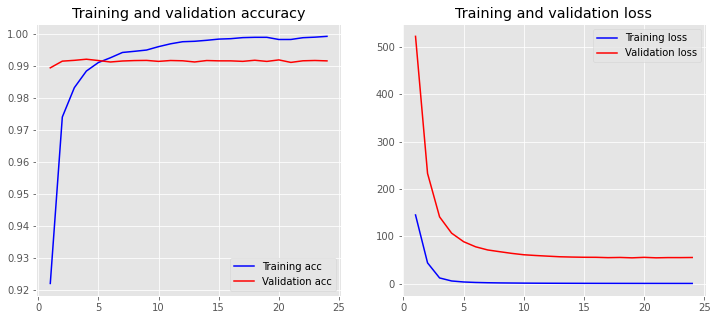

32/32 [==============================] - 10s 207ms/step
F1-score: 69.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.75604670558799,0.7194444444444444,0.7372915819438798,5040.0
Disease,0.6557597489914836,0.6591574678981753,0.6574542186271205,4439.0
micro avg,0.7077122488658457,0.6912121531807153,0.6993648929924748,9479.0
macro avg,0.7059032272897368,0.6893009561713099,0.6973729002855001,9479.0
weighted avg,0.709082489918416,0.6912121531807153,0.6999038769366961,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 1500
Points in y_train after augmentation: 1500
Converted 11117 words (7875 misses)
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_39 (Embedding)    (None, 651, 100)          1899300   
                                                                 
 bidirectional_39 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_39 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_39 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,061,130
Trainable params: 2,061,130
Non-trainab

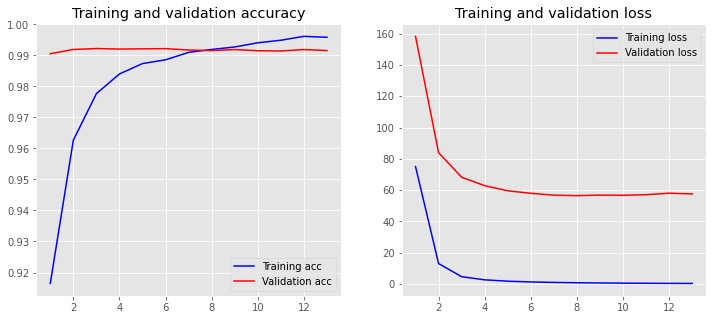

32/32 [==============================] - 10s 207ms/step
F1-score: 69.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8155225288983251,0.6859126984126984,0.7451233969177713,5040.0
Disease,0.6230333543108874,0.6690696102725839,0.6452313708451011,4439.0
micro avg,0.7136353542083056,0.6780251081337694,0.695374628076819,9479.0
macro avg,0.7192779416046062,0.6774911543426412,0.6951773838814361,9479.0
weighted avg,0.725380167257473,0.6780251081337694,0.6983441265583892,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Converted 11261 words (7991 misses)
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_40 (Embedding)    (None, 651, 100)          1925300   
                                                                 
 bidirectional_40 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_40 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_40 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,087,130
Trainable params: 2,087,130
Non-trainab

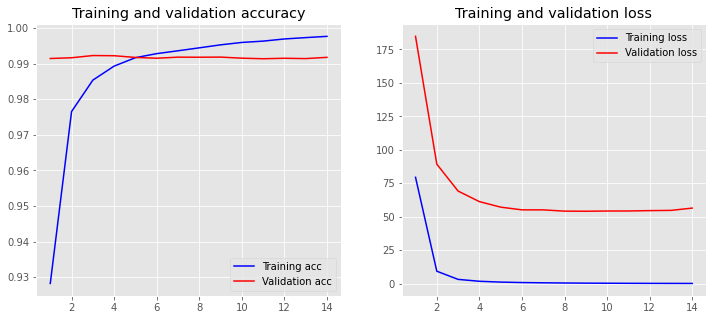

32/32 [==============================] - 10s 206ms/step
F1-score: 70.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8241279069767442,0.675,0.7421465968586388,5040.0
Disease,0.6929973346256361,0.6442892543365623,0.6677562456222274,4439.0
micro avg,0.7585705632949727,0.6606182086718009,0.7062140521033043,9479.0
macro avg,0.7585626208011902,0.6596446271682812,0.7049514212404331,9479.0
weighted avg,0.7627196771353507,0.6606182086718009,0.7073097185868348,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Converted 11260 words (8018 misses)
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_41 (Embedding)    (None, 651, 100)          1927900   
                                                                 
 bidirectional_41 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_41 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_41 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,089,730
Trainable params: 2,089,730
Non-trainab

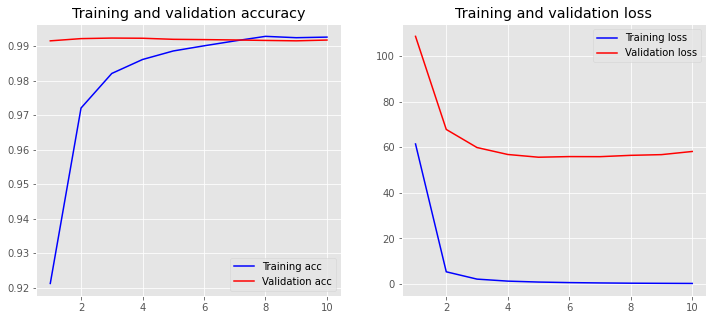

32/32 [==============================] - 10s 207ms/step
F1-score: 71.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8042778288868445,0.6938492063492063,0.7449936088623775,5040.0
Disease,0.7199595244118391,0.6411353908537959,0.6782650142993327,4439.0
micro avg,0.7641248042404529,0.6691634138622218,0.7134983127109111,9479.0
macro avg,0.7621186766493417,0.667492298601501,0.7116293115808552,9479.0
weighted avg,0.7647917065570049,0.6691634138622218,0.7137447185505983,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Converted 11275 words (7990 misses)
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_42 (Embedding)    (None, 651, 100)          1926600   
                                                                 
 bidirectional_42 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_42 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_42 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,088,430
Trainable params: 2,088,430
Non-trainab

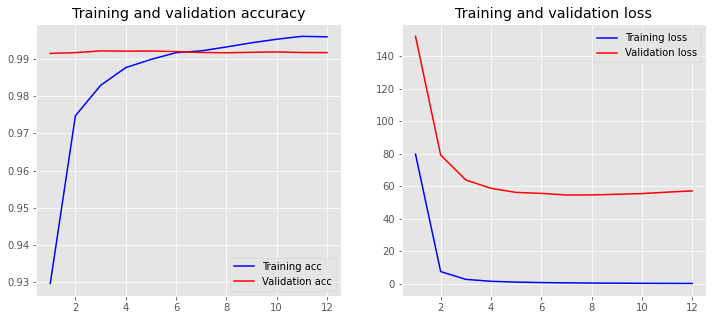

32/32 [==============================] - 10s 211ms/step
F1-score: 70.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8254728273880776,0.6841269841269841,0.7481827058695888,5040.0
Disease,0.6880689985625299,0.6469925658932192,0.6668988737954256,4439.0
micro avg,0.7567955933421148,0.6667369975735837,0.7089175546831185,9479.0
macro avg,0.7567709129753037,0.6655597750101017,0.7075407898325072,9479.0
weighted avg,0.761126841930054,0.6667369975735837,0.7101176219390887,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Converted 11253 words (7999 misses)
Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_43 (Embedding)    (None, 651, 100)          1925300   
                                                                 
 bidirectional_43 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_43 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_43 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,087,130
Trainable params: 2,087,130
Non-trainab

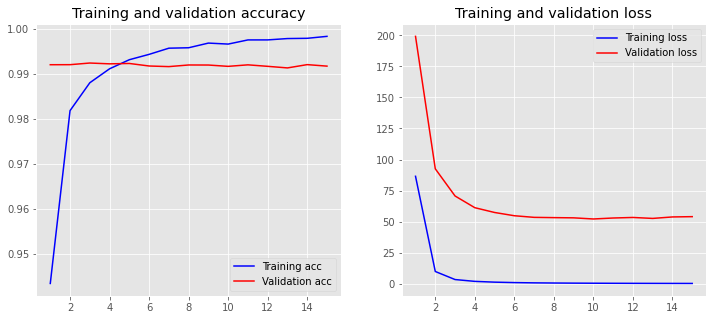

32/32 [==============================] - 10s 203ms/step
F1-score: 70.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7261418853255588,0.7412698412698413,0.7336278841433481,5040.0
Disease,0.6743970315398887,0.6551025005631899,0.6646097588846989,4439.0
micro avg,0.7025483768636989,0.7009178183352675,0.7017321504013521,9479.0
macro avg,0.7002694584327238,0.6981861709165156,0.6991188215140235,9479.0
weighted avg,0.7019098560023612,0.7009178183352675,0.7013068103989506,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Converted 11259 words (7982 misses)
Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_44 (Embedding)    (None, 651, 100)          1924200   
                                                                 
 bidirectional_44 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_44 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_44 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,086,030
Trainable params: 2,086,030
Non-trainab

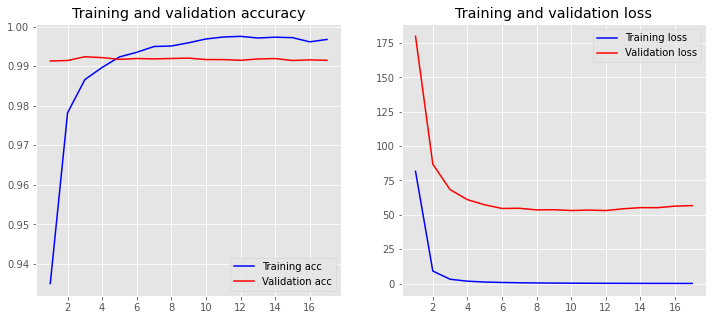

32/32 [==============================] - 10s 205ms/step
F1-score: 69.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7246488358668463,0.7472222222222222,0.7357624303995312,5040.0
Disease,0.6474583698510079,0.6656904708267628,0.6564478507164279,4439.0
micro avg,0.6885565003585699,0.7090410380841861,0.6986486486486486,9479.0
macro avg,0.686053602858927,0.7064563465244925,0.6961051405579795,9479.0
weighted avg,0.6885006684816467,0.7090410380841861,0.6986195441021058,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Converted 11248 words (7993 misses)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_45 (Embedding)    (None, 651, 100)          1924200   
                                                                 
 bidirectional_45 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_45 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_45 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,086,030
Trainable params: 2,086,030
Non-trainab

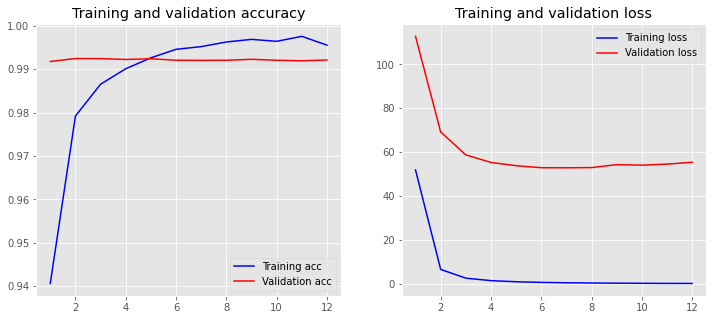

32/32 [==============================] - 10s 209ms/step
F1-score: 71.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7872898012666522,0.7152777777777778,0.7495581661295353,5040.0
Disease,0.6922894424673784,0.6573552601937374,0.6743702334180726,4439.0
micro avg,0.7417557425517398,0.6881527587298238,0.7139495430416463,9479.0
macro avg,0.7397896218670152,0.6863165189857576,0.711964199773804,9479.0
weighted avg,0.7428012905893681,0.6881527587298238,0.7143477817739933,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Converted 11254 words (7986 misses)
Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_46 (Embedding)    (None, 651, 100)          1924100   
                                                                 
 bidirectional_46 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_46 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_46 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,085,930
Trainable params: 2,085,930
Non-trainab

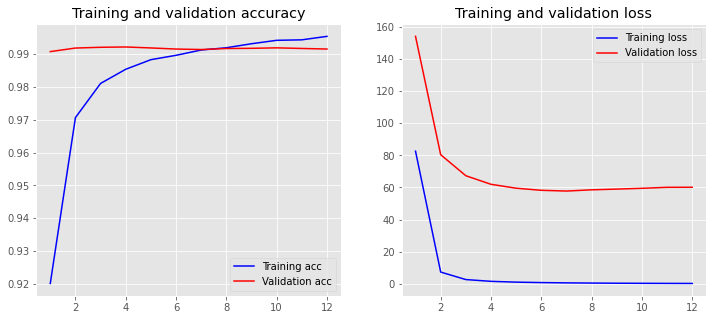

32/32 [==============================] - 10s 208ms/step
F1-score: 69.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8443037974683544,0.6617063492063492,0.7419354838709677,5040.0
Disease,0.6184863523573201,0.6738004054967335,0.6449595687331536,4439.0
micro avg,0.7200091053949466,0.6673699757358371,0.6926909389542842,9479.0
macro avg,0.7313950749128373,0.6677533773515414,0.6934475263020607,9479.0
weighted avg,0.7385538619426786,0.6673699757358371,0.6965218234324451,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Converted 11246 words (7969 misses)
Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_47 (Embedding)    (None, 651, 100)          1921600   
                                                                 
 bidirectional_47 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_47 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_47 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,083,430
Trainable params: 2,083,430
Non-trainab

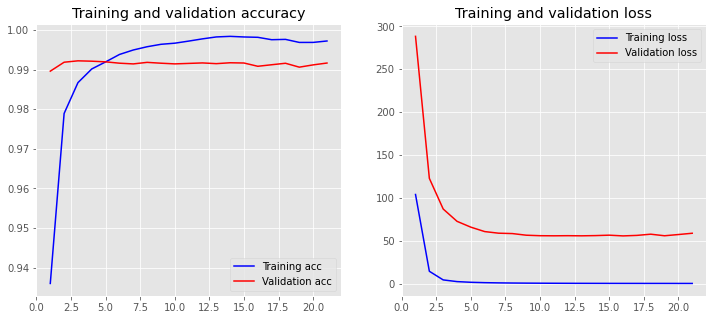

32/32 [==============================] - 10s 209ms/step
F1-score: 68.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7774863387978143,0.7057539682539683,0.739885595423817,5040.0
Disease,0.6037659445231829,0.6717729218292409,0.6359564939219451,4439.0
micro avg,0.6873029220096699,0.6898407004958329,0.6885694729637234,9479.0
macro avg,0.6906261416604986,0.6887634450416046,0.6879210446728811,9479.0
weighted avg,0.6961333658908527,0.6898407004958329,0.6912157693275189,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Converted 11254 words (7974 misses)
Model: "sequential_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_48 (Embedding)    (None, 651, 100)          1922900   
                                                                 
 bidirectional_48 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_48 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_48 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,084,730
Trainable params: 2,084,730
Non-trainab

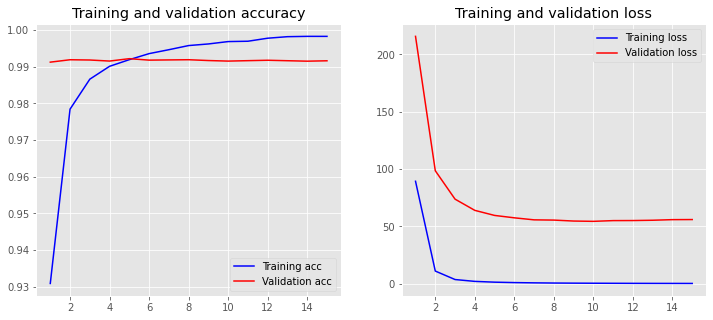

32/32 [==============================] - 10s 207ms/step
F1-score: 69.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7863855145542058,0.6807539682539683,0.7297670956077847,5040.0
Disease,0.6652930402930403,0.6546519486370804,0.6599296014533894,4439.0
micro avg,0.7258046042835872,0.6685304356999684,0.6959912136188908,9479.0
macro avg,0.7258392774236231,0.6677029584455243,0.6948483485305871,9479.0
weighted avg,0.7296781094223023,0.6685304356999684,0.6970623127666242,9479.0

!!!!!! Starting model number 10 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 2250
Points in y_train after augmentation: 2250
Converted 11272 words (8018 misses)
Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_49 (Embedding)    (None, 651, 100)          1929100   
                                                                 
 bidirectional_49 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_49 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_49 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,090,930
Trainable params: 2,090,930
Non-trainab

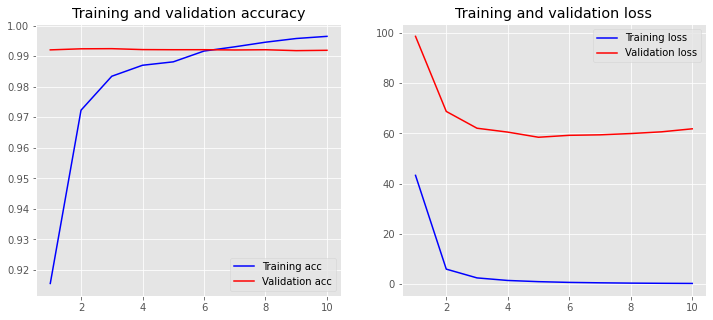

32/32 [==============================] - 10s 209ms/step
F1-score: 71.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8495275018173007,0.6956349206349206,0.7649176393585687,5040.0
Disease,0.6638938848920863,0.6652399189006533,0.6645662203218184,4439.0
micro avg,0.7532361516034985,0.6814009916657875,0.7155201063476238,9479.0
macro avg,0.7567106933546935,0.6804374197677869,0.7147419298401936,9479.0
weighted avg,0.7625955864748567,0.6814009916657875,0.7179232360349972,9479.0



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Converted 11636 words (8236 misses)
Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_50 (Embedding)    (None, 651, 100)          1987300   
                                                                 
 bidirectional_50 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_50 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_50 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,149,130
Trainable params: 2,149,130
Non-trainab

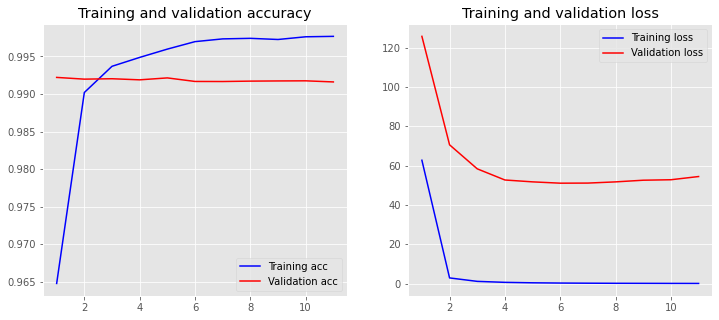

32/32 [==============================] - 10s 210ms/step
F1-score: 70.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8158985613265057,0.6638888888888889,0.7320862050103926,5040.0
Disease,0.6890776126444916,0.6580310880829016,0.6731965890758239,4439.0
micro avg,0.7514388489208633,0.6611456904736787,0.7034064762332342,9479.0
macro avg,0.7524880869854986,0.6609599884858952,0.7026413970431082,9479.0
weighted avg,0.7565085211113501,0.6611456904736787,0.7045082954066844,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Converted 11624 words (8237 misses)
Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_51 (Embedding)    (None, 651, 100)          1986200   
                                                                 
 bidirectional_51 (Bidirecti  (None, 651, 200)         160800    
 onal)                                                           
                                                                 
 time_distributed_51 (TimeDi  (None, 651, 5)           1005      
 stributed)                                                      
                                                                 
 crf_51 (CRF)                (None, 651, 5)            25        
                                                                 
Total params: 2,148,030
Trainable params: 2,148,030
Non-trainab

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!


Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Converted 11653 words (8242 misses)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 651, 100)          1989600   
                                                                 
 bidirectional (Bidirectiona  (None, 651, 200)         160800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 651, 5)           1005      
 ibuted)                                                         
                                                                 
 crf (CRF)                   (None, 651, 5)            25        
                                                                 
Total params: 2,151,430
Trainable params: 2,151,430
Non-trainable 

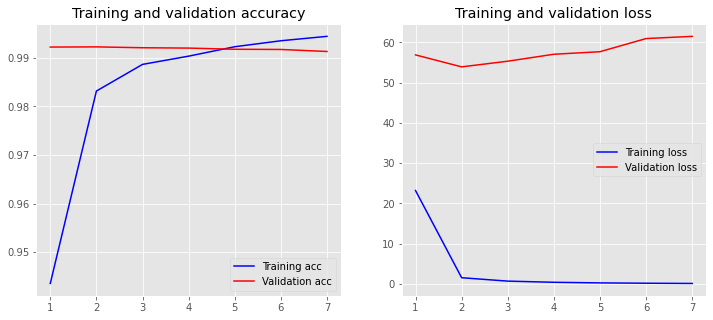

32/32 [==============================] - 9s 196ms/step
F1-score: 71.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.9006696428571429,0.6404761904761904,0.74860853432282,5040.0
Disease,0.7344782034346103,0.626267177292183,0.6760700389105059,4439.0
micro avg,0.8153073687067445,0.6338221331364068,0.7132003798670467,9479.0
macro avg,0.8175739231458766,0.6333716838841867,0.7123392866166629,9479.0
weighted avg,0.822842467037265,0.6338221331364068,0.7146388770662252,9479.0

!!!!!! Starting model number 2 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Converted 11610 words (8234 misses)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 651, 100)          1984500   
                                                                 
 bidirectional_1 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_1 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,146,330
Trainable params: 2,146,330
Non-trainabl

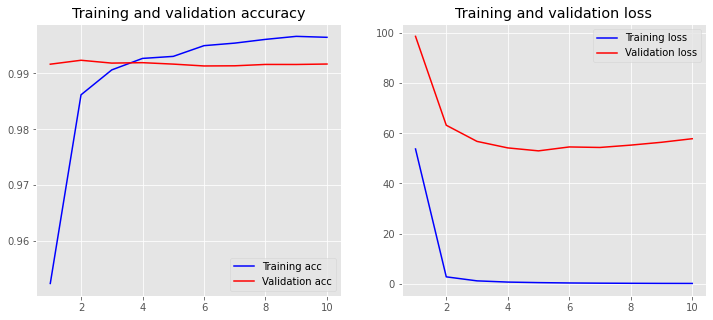

32/32 [==============================] - 9s 201ms/step
F1-score: 69.7%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7769093345243412,0.6902777777777778,0.7310359319184702,5040.0
Disease,0.6955756661639014,0.6233385897724713,0.6574789117262682,4439.0
micro avg,0.738647114474929,0.6589302669057917,0.6965151937552272,9479.0
macro avg,0.7362425003441213,0.6568081837751245,0.6942574218223692,9479.0
weighted avg,0.7388209123435212,0.6589302669057917,0.6965893011944291,9479.0

!!!!!! Starting model number 3 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Converted 11658 words (8251 misses)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 651, 100)          1991000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,152,830
Trainable params: 2,152,830
Non-trainabl

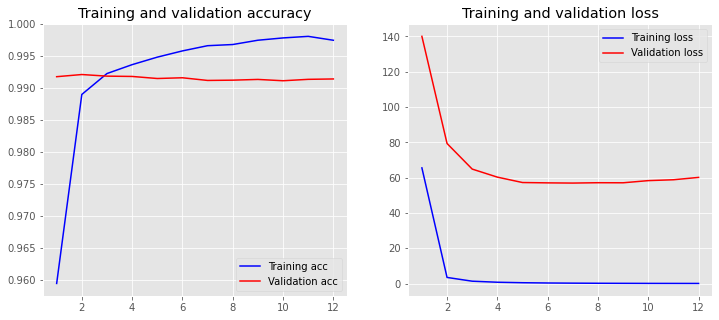

32/32 [==============================] - 9s 197ms/step
F1-score: 68.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8102281273502131,0.6412698412698413,0.715915383763429,5040.0
Disease,0.6624940954180444,0.6318990763685515,0.646835005188516,4439.0
micro avg,0.7341602821354737,0.6368815275872982,0.6820698226189131,9479.0
macro avg,0.7363611113841287,0.6365844588191965,0.6813751944759725,9479.0
weighted avg,0.7410445248872004,0.6368815275872982,0.6835651568941349,9479.0

!!!!!! Starting model number 4 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Converted 11582 words (8243 misses)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 651, 100)          1982600   
                                                                 
 bidirectional_3 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_3 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_3 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,144,430
Trainable params: 2,144,430
Non-trainabl

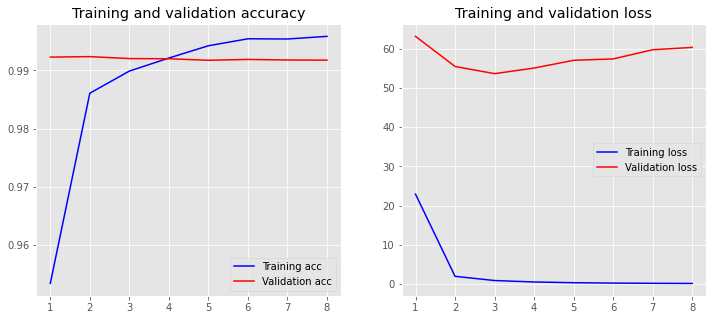

32/32 [==============================] - 9s 195ms/step
F1-score: 71.6%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8319612590799031,0.6817460317460318,0.7494002181025081,5040.0
Disease,0.6913063691306369,0.6699707141248029,0.6804713419517218,4439.0
micro avg,0.7601992409867173,0.6762316700073847,0.7157612640276925,9479.0
macro avg,0.7616338141052701,0.6758583729354173,0.714935780027115,9479.0
weighted avg,0.7660928070823514,0.6762316700073847,0.7171209395675002,9479.0

!!!!!! Starting model number 5 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Converted 11633 words (8269 misses)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 651, 100)          1990300   
                                                                 
 bidirectional_4 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_4 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_4 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,152,130
Trainable params: 2,152,130
Non-trainabl

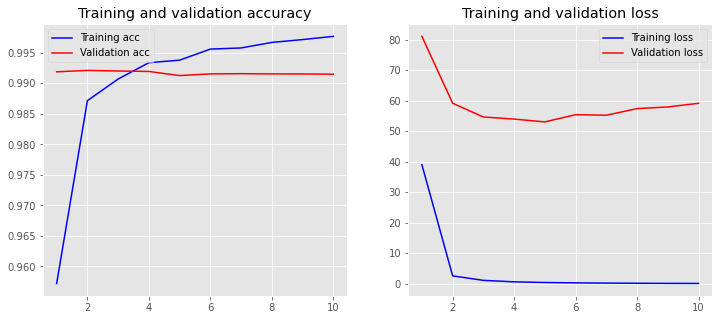

32/32 [==============================] - 9s 192ms/step
F1-score: 68.5%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7326959052172105,0.6994047619047619,0.7156633844279768,5040.0
Disease,0.6590542099192618,0.643613426447398,0.6512423068155915,4439.0
micro avg,0.6977913842116772,0.6732777719168689,0.6853154362416107,9479.0
macro avg,0.6958750575682362,0.67150909417608,0.6834528456217841,9479.0
weighted avg,0.6982096212813951,0.6732777719168689,0.6854951004822675,9479.0

!!!!!! Starting model number 6 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Converted 11614 words (8247 misses)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 651, 100)          1986200   
                                                                 
 bidirectional_5 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_5 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_5 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,148,030
Trainable params: 2,148,030
Non-trainabl

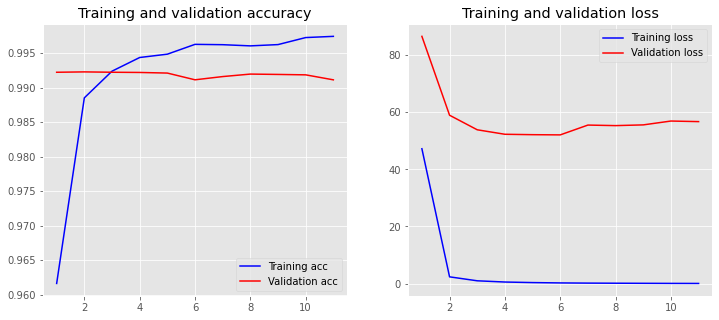

32/32 [==============================] - 9s 196ms/step
F1-score: 69.2%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.748080204778157,0.6958333333333333,0.7210115131578947,5040.0
Disease,0.679990426041168,0.6400090110385221,0.6593942207264709,4439.0
micro avg,0.7159936837356192,0.6696908956640996,0.6920686835650041,9479.0
macro avg,0.7140353154096625,0.6679211721859277,0.6902028669421828,9479.0
weighted avg,0.7161938741722392,0.6696908956640996,0.6921562371685404,9479.0

!!!!!! Starting model number 7 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Converted 11525 words (8199 misses)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 651, 100)          1972500   
                                                                 
 bidirectional_6 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_6 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,134,330
Trainable params: 2,134,330
Non-trainabl

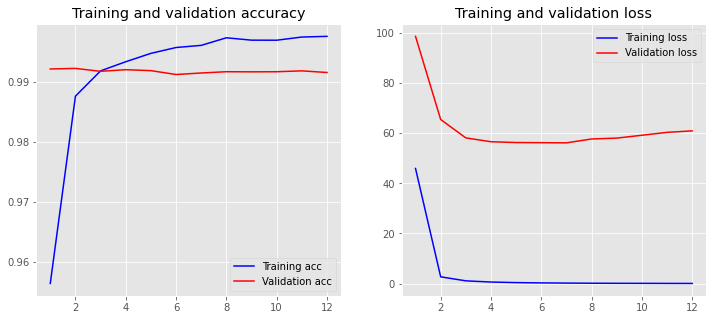

32/32 [==============================] - 9s 200ms/step
F1-score: 70.3%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.7799867461895295,0.700595238095238,0.7381624333646911,5040.0
Disease,0.6848137535816619,0.6460914620410002,0.6648893010316449,4439.0
micro avg,0.734251290877797,0.6750712100432535,0.7034187094646588,9479.0
macro avg,0.7324002498855957,0.6733433500681192,0.701525867198168,9479.0
weighted avg,0.735417391385613,0.6750712100432535,0.7038487468548913,9479.0

!!!!!! Starting model number 8 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Converted 11604 words (8241 misses)
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 651, 100)          1984600   
                                                                 
 bidirectional_7 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_7 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_7 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,146,430
Trainable params: 2,146,430
Non-trainabl

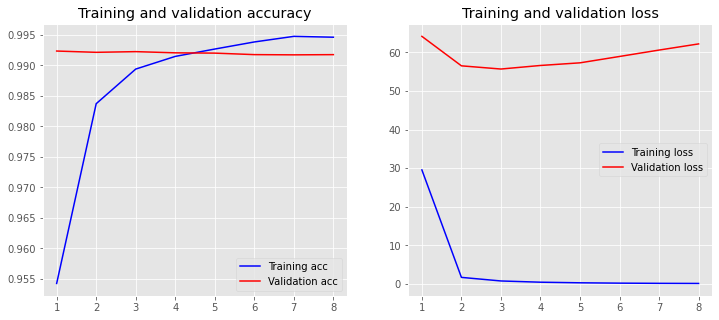

32/32 [==============================] - 9s 201ms/step
F1-score: 70.4%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8905775075987842,0.6394841269841269,0.7444277630211341,5040.0
Disease,0.7353266888150609,0.5983329578733949,0.6597938144329897,4439.0
micro avg,0.8130272438113677,0.6202131026479586,0.7036505086774386,9479.0
macro avg,0.8129520982069225,0.6189085424287609,0.7021107887270619,9479.0
weighted avg,0.8178738063031888,0.6202131026479586,0.7047938250759107,9479.0

!!!!!! Starting model number 9 !!!!!!


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Points in X_train after augmentation: 4500
Points in y_train after augmentation: 4500
Converted 11612 words (8225 misses)
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 651, 100)          1983800   
                                                                 
 bidirectional_8 (Bidirectio  (None, 651, 200)         160800    
 nal)                                                            
                                                                 
 time_distributed_8 (TimeDis  (None, 651, 5)           1005      
 tributed)                                                       
                                                                 
 crf_8 (CRF)                 (None, 651, 5)            25        
                                                                 
Total params: 2,145,630
Trainable params: 2,145,630
Non-trainabl

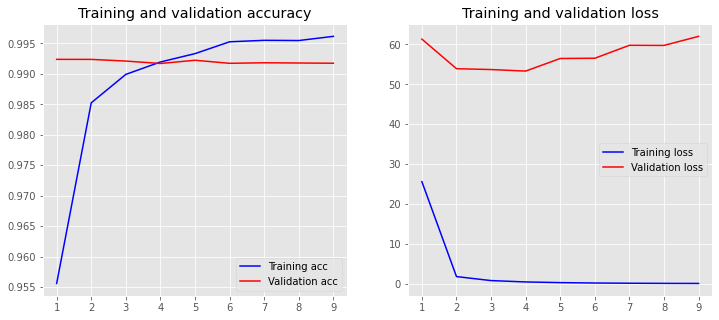

32/32 [==============================] - 9s 195ms/step
F1-score: 70.9%
Classification Report:
,precision,recall,f1-score,support
Chemical,0.8016528925619835,0.7121031746031746,0.7542292739308605,5040.0
Disease,0.6476046611998274,0.6760531651272809,0.6615232007053895,4439.0
micro avg,0.7233015036768741,0.6952210148749868,0.7089833243679396,9479.0
macro avg,0.7246287768809054,0.6940781698652277,0.707876237318125,9479.0
weighted avg,0.7295123609640712,0.6952210148749868,0.7108151733877793,9479.0



In [13]:
number_of_training_models = 9
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)